<a href="https://colab.research.google.com/github/Suhit97/BERT-Sentitment-analysis-review-dataset/blob/master/BERT_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')  



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 778kB 5.0MB/s 
     |████████████████████████████████| 3.0MB 25.6MB/s 
     |████████████████████████████████| 1.1MB 53.1MB/s 
     |████████████████████████████████| 890kB 32.7MB/s 


In [ ]:
import transformers

from transformers import BertModel, BertTokenizer

import pandas as pd

import torch
import torch.nn as nn
from tqdm import tqdm


from sklearn import model_selection
from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
import numpy as np

In [ ]:
import zipfile

local_zip = '/content/gdrive/My Drive/Sentiment/sentiment140.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/gdrive/My Drive/Sentiment')
zip_ref.close()

In [ ]:

MAX_LEN = 150
TRAIN_BATCH_SIZE = 50
VALID_BATCH_SIZE = 10
EPOCHS = 10
BERT_PATH = "../input/bert_base_uncased/"
MODEL_PATH = "model.bin"
TRAINING_PATH = '/content/gdrive/My Drive/Sentiment/training.1600000.processed.noemoticon.csv'
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
TOKENIZER =  BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [ ]:
df = pd.read_csv(TRAINING_PATH, encoding ="ISO-8859-1" ,
                 header=None)
df.head()


,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   query      1600000 non-null  object
 4   user_id    1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
df.describe(include = 'O')


,date,query,user_id,text
count,1600000,1600000,1600000,1600000
unique,774363,1,659775,1581466
top,Mon Jun 15 12:53:14 PDT 2009,NO_QUERY,lost_dog,isPlayer Has Died! Sorry
freq,20,1600000,549,210


In [ ]:
#Checking for null values
df.isnull().any()

sentiment    False
id           False
date         False
query        False
user_id      False
text         False
dtype: bool

In [ ]:
df.isnull().sum()


sentiment    0
id           0
date         0
query        0
user_id      0
text         0
dtype: int64

In [ ]:
# Checking the target values
df.sentiment.value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

In [ ]:
import re
import string


def remove_noise(text):
    # Dealing with Punctuation
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('@\S+|https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    #Only this one can be used
    #text = re.sub('@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+', '', text)
    return text



In [ ]:
# Applying the remove_noise function on the dataset
df['text'] = df['text'].apply(lambda x : remove_noise(x))
#Converting the uppercase letters to lower case
df['text'] = df['text'].apply(lambda x : x.lower())
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww thats a bummer you shoulda got david ...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he cant update his facebook by t...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,i dived many times for the ball managed to sa...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no its not behaving at all im mad why am i he...


In [ ]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,id,date,query,user_id,text
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww thats a bummer you shoulda got david ...
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he cant update his facebook by t...
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,i dived many times for the ball managed to sa...
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no its not behaving at all im mad why am i he...


Text(0.5, 1.0, 'Sentiment Data Distribution')

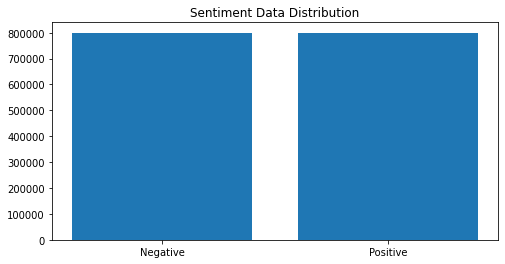

In [ ]:
import matplotlib.pyplot as plt


val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [ ]:
import random
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,sentiment,id,date,query,user_id,text
982883,Positive,1834244389,Mon May 18 02:11:08 PDT 2009,NO_QUERY,neo_indian,that will be decided in hindsight as always i...
209466,Negative,1973982184,Sat May 30 12:12:35 PDT 2009,NO_QUERY,bettyflies,my other coworkers being quottwitter myspace ...
1499811,Positive,2070973972,Sun Jun 07 18:37:01 PDT 2009,NO_QUERY,colbertobsessed,hell yeah cliqueoftwitter
1392305,Positive,2053398127,Sat Jun 06 04:24:45 PDT 2009,NO_QUERY,danphelan,new layout on nadineweborg please check it out
654394,Negative,2239391618,Fri Jun 19 08:29:13 PDT 2009,NO_QUERY,CLOTHESMINDED1,answer on the road nola im hungry with ...
26613,Negative,1558821628,Sun Apr 19 09:29:52 PDT 2009,NO_QUERY,alenacarran,woke up on the wrong side of the bed
1091460,Positive,1969890422,Sat May 30 01:37:04 PDT 2009,NO_QUERY,atheistium,man i am not really a guitar hero fan but dj h...
294437,Negative,1996595581,Mon Jun 01 15:21:08 PDT 2009,NO_QUERY,Nquoid,ea whilst that was great where the hell was ha...
354236,Negative,2039667984,Thu Jun 04 22:30:40 PDT 2009,NO_QUERY,kryptongirl,oh man thats not cool
1125278,Positive,1974812276,Sat May 30 13:53:21 PDT 2009,NO_QUERY,Humble63,my boy jus walked the stage couldnt hear his n...


In [ ]:
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

def preprocess(text, stem=False):
  # already done
  #text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

df.text = df.text.apply(lambda x: preprocess(x))

df['text'].head()



0    awww thats bummer shoulda got david carr third...
1    upset cant update facebook texting might cry r...
2    dived many times ball managed save rest go bounds
3                     whole body feels itchy like fire
4                             behaving im mad cant see
Name: text, dtype: object

In [ ]:
#Saving the cleaned one for future use
df.to_csv('/content/gdrive/My Drive/Sentiment/Cleaned_text.csv')



In [ ]:
TRAINING_FILE ='/content/gdrive/My Drive/Sentiment/Cleaned_text.csv'

In [ ]:
df_check = pd.read_csv(TRAINING_FILE)
df_check.head()


,Unnamed: 0,sentiment,id,date,query,user_id,text
0,0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww thats bummer shoulda got david carr third...
1,1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset cant update facebook texting might cry r...
2,2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save rest go bounds
3,3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving im mad cant see


In [ ]:
class BERTDataset:
    def __init__(self, review, target):
        self.review = review
        self.target = target
        self.tokenizer = TOKENIZER
        self.max_len = MAX_LEN

    def __len__(self):
        return len(self.review)

    def __getitem__(self, item):
        review = str(self.review[item])
        review = " ".join(review.split())

        inputs = self.tokenizer.encode_plus(
            review,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
        )

        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "targets": torch.tensor(self.target[item], dtype=torch.float),
        }

In [ ]:
def loss_fn(outputs, targets):
    return nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))


def train_fn(data_loader, model, optimizer, device, scheduler):
    model.train()

    for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
        ids = d["ids"]
        token_type_ids = d["token_type_ids"]
        mask = d["mask"]
        targets = d["targets"]

        ids = ids.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)

        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()


def eval_fn(data_loader, model, device):
    model.eval()
    fin_targets = []
    fin_outputs = []
    with torch.no_grad():
        for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
            ids = d["ids"]
            token_type_ids = d["token_type_ids"]
            mask = d["mask"]
            targets = d["targets"]

            ids = ids.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.float)

            outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [ ]:

class BERTBaseUncased(nn.Module):
    def __init__(self):
        super(BERTBaseUncased, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.bert_drop = nn.Dropout(0.3)
        self.out = nn.Linear(768, 1)

    def forward(self, ids, mask, token_type_ids):
        _, o2 = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        bo = self.bert_drop(o2)
        output = self.out(bo)
        return output

In [ ]:

def run():
    dfx = pd.read_csv(TRAINING_FILE).fillna("none")
    dfx.sentiment = dfx.sentiment.apply(lambda x: 1 if x == "Positive" else 0)

    df_train, df_valid = model_selection.train_test_split(
        dfx, test_size=0.1, random_state=42, stratify=dfx.sentiment.values
    )

    df_train = df_train.reset_index(drop=True)
    df_valid = df_valid.reset_index(drop=True)

    train_dataset = BERTDataset(
        review=df_train.text.values, target=df_train.sentiment.values
    )

    train_data_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size= TRAIN_BATCH_SIZE, num_workers=4
    )

    valid_dataset = BERTDataset(
        review=df_valid.text.values, target=df_valid.sentiment.values
    )

    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=VALID_BATCH_SIZE, num_workers=1
    )

    device = torch.device("cuda")
    model = BERTBaseUncased()
    model.to(device)

    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {
            "params": [
                p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.001,
        },
        {
            "params": [
                p for n, p in param_optimizer if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]

    num_train_steps = int(len(df_train) / TRAIN_BATCH_SIZE * EPOCHS)
    optimizer = AdamW(optimizer_parameters, lr=3e-5)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
    )

    model = nn.DataParallel(model)

    best_accuracy = 0
    for epoch in range(EPOCHS):
        train_fn(train_data_loader, model, optimizer, device, scheduler)
        outputs, targets = eval_fn(valid_data_loader, model, device)
        outputs = np.array(outputs) >= 0.5
        accuracy = metrics.accuracy_score(targets, outputs)
        print(f"Accuracy Score = {accuracy}")
        if accuracy > best_accuracy:
            torch.save(model.state_dict(), MODEL_PATH)
            best_accuracy = accuracy




In [ ]:
if __name__ == "__main__":
   run()

   

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (